In [22]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import copy
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as LR

import torchvision
import torchvision.transforms as transforms

In [23]:
class NN(nn.Module):
    def __init__(self, layersize, eta=None):
        super(NN, self).__init__()
        
        self.register_buffer('alpha', torch.ones(layersize))
        self.register_buffer('beta', torch.zeros(layersize))

    def forward(self, x):
        return x
    
    def update(self, u, v, eta=None):
        pass
    


class Adam(nn.Module):
    def __init__(self, param, betas=(0.9, 0.999), eps=1e-8):
        super(Adam, self).__init__()

        self.register_buffer('beta1', torch.tensor(betas[0]))
        self.register_buffer('beta2', torch.tensor(betas[1]))
        self.register_buffer('eps', torch.tensor(eps))

        self.register_buffer('m', torch.zeros_like(param))
        self.register_buffer('v', torch.zeros_like(param))
        self.register_buffer('t', torch.tensor(0.0))

    def forward(self, g):
        self.m = self.beta1 * self.m + (1-self.beta1) * g
        self.v = self.beta2 * self.v + (1-self.beta2) * g**2
        self.t += 1

        m_hat = self.m/(1 - self.beta1**self.t)
        v_hat = self.v/(1 - self.beta2**self.t)

        return m_hat / (torch.sqrt(v_hat) + self.eps)


class IP(nn.Module):
    def __init__(self, layersize, eta=1):
        super(IP, self).__init__()
        self.eta = eta
        
        # Alpha and beta are the ip normalization parameters
        self.register_buffer('alpha', torch.ones(layersize))
        self.register_buffer('beta', torch.zeros(layersize))
        
        self.adjust_a = Adam(self.alpha)
        self.adjust_b = Adam(self.beta)
        
    def forward(self, x):

        # Normalize
        nx = (x-self.beta)/self.alpha

        return  nx
        
    def update(self, u, v, eta=None):

        if (eta is None):
            eta = self.eta
        
        with torch.no_grad():
            Ev = v.mean(0, keepdim=True)
            Euv = (u*v).mean(0, keepdim=True)

        self.alpha = (1-eta)*self.alpha + eta*2*Euv
        self.beta = self.beta + eta*2*Ev*Euv
#         for n in self.alpha:
#             for gain in n:
#                 if(gain != abs(gain)):
#                     print("FLAG!")
        
#         self.eta = eta * 0.999


class DNet(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(DNet, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(28*28, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, layersize)
        self.fc4 = nn.Linear(layersize, layersize)
        self.fc5 = nn.Linear(layersize, layersize)
        self.fc6 = nn.Linear(layersize, layersize)
        self.fc7 = nn.Linear(layersize, layersize)
        self.fc8 = nn.Linear(layersize, layersize)
        self.fc9 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        self.n3 = norm(layersize, eta)
        self.n4 = norm(layersize, eta)
        self.n5 = norm(layersize, eta)
        self.n6 = norm(layersize, eta)
        self.n7 = norm(layersize, eta)
        self.n8 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 28*28)
        u1 = self.fc1(x)
        v1 = torch.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = torch.tanh(self.n2(u2))
        u3 = self.fc3(v2)
        v3 = torch.tanh(self.n3(u3))
        u4 = self.fc4(v3)
        v4 = torch.tanh(self.n4(u4))
        u5 = self.fc5(v4)
        v5 = torch.tanh(self.n5(u5))
        u6 = self.fc6(v5)
        v6 = torch.tanh(self.n6(u6))
        u7 = self.fc7(v6)
        v7 = torch.tanh(self.n7(u7))
        u8 = self.fc8(v7)
        v8 = torch.tanh(self.n8(u8))
        # Note you should not normalize after the last linear layer (you delete info)
        o = F.relu(self.fc9(v8))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        self.n3.update(u3, v3, eta)
        self.n4.update(u4, v4, eta)
        self.n5.update(u5, v5, eta)
        self.n6.update(u6, v6, eta)
        self.n7.update(u7, v7, eta)
        self.n8.update(u8, v8, eta)
        
        return o

In [24]:
class CDNet(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(CDNet, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(3*32*32, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, layersize)
        self.fc4 = nn.Linear(layersize, layersize)
        self.fc5 = nn.Linear(layersize, layersize)
        self.fc6 = nn.Linear(layersize, layersize)
        self.fc7 = nn.Linear(layersize, layersize)
        self.fc8 = nn.Linear(layersize, layersize)
        self.fc9 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        self.n3 = norm(layersize, eta)
        self.n4 = norm(layersize, eta)
        self.n5 = norm(layersize, eta)
        self.n6 = norm(layersize, eta)
        self.n7 = norm(layersize, eta)
        self.n8 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 3*32*32)
        u1 = self.fc1(x)
        v1 = torch.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = torch.tanh(self.n2(u2))
        u3 = self.fc3(v2)
        v3 = torch.tanh(self.n3(u3))
        u4 = self.fc4(v3)
        v4 = torch.tanh(self.n4(u4))
        u5 = self.fc5(v4)
        v5 = torch.tanh(self.n5(u5))
        u6 = self.fc6(v5)
        v6 = torch.tanh(self.n6(u6))
        u7 = self.fc7(v6)
        v7 = torch.tanh(self.n7(u7))
        u8 = self.fc8(v7)
        v8 = torch.tanh(self.n8(u8))
        # Note you should not normalize after the last linear layer (you delete info)
        o = F.relu(self.fc9(v8))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        self.n3.update(u3, v3, eta)
        self.n4.update(u4, v4, eta)
        self.n5.update(u5, v5, eta)
        self.n6.update(u6, v6, eta)
        self.n7.update(u7, v7, eta)
        self.n8.update(u8, v8, eta)
        
        return o

In [25]:
def train_deep_model(network, optimization, seed, epochs):
    
    criterion = nn.CrossEntropyLoss()
    torch.manual_seed(seed)
    
    loss_tracker = []
    episode = 1
    
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        i = 0
        
        for i, data in enumerate(trainloader):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimization.zero_grad()

            # forward + backward + optimize
            y = network(inputs)
            loss = criterion(y, labels)
            loss.backward()
            optimization.step()

            # update statistics
            running_loss += loss.item()
            i += 0
            
            loss_tracker.append([episode,loss.item()])
            episode += 1
            
        print('[%d] loss: %.3f' %
                      (epoch + 1,running_loss / i))
    
#     print(abs(network.n1.beta.max(0)[0]).max(0))
#     print("Largest beta is ", max(abs(network.n1.beta.max(0)[0]).max(0),
#                    abs(network.n2.beta.max(0)[0]).max(0),
#                    abs(network.n3.beta.max(0)[0]).max(0),
#                    abs(network.n4.beta.max(0)[0]).max(0),
#                    abs(network.n5.beta.max(0)[0]).max(0),
#                    abs(network.n6.beta.max(0)[0]).max(0),
#                    abs(network.n7.beta.max(0)[0]).max(0),
#                    abs(network.n8.beta.max(0)[0]).max(0)))
#     print("Largest weight is ", max(abs(network.fc1.weight.max(0)[0]).max(0),
#               abs(network.fc2.weight.max(0)[0]).max(0),
#               abs(network.fc3.weight.max(0)[0]).max(0),
#               abs(network.fc4.weight.max(0)[0]).max(0),
#               abs(network.fc5.weight.max(0)[0]).max(0),
#               abs(network.fc6.weight.max(0)[0]).max(0),
#               abs(network.fc7.weight.max(0)[0]).max(0),
#               abs(network.fc8.weight.max(0)[0]).max(0)))
    
    print("Finished training!\n")
    return(np.transpose(loss_tracker))


def run_cifar_experiment(int_lr, syn_lr, epochs, test_runs, filename):
    seed = random.randint(0, 1000000)

    #Train IP Model
    torch.manual_seed(seed)
    IPnet = CDNet(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net. Run 1")
    ip_losses = train_deep_model(IPnet, optimizer1, seed, epochs)


    #Train Standard Model
    torch.manual_seed(seed)
    net = CDNet(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net. Run 1")
    standard_losses = train_deep_model(net, optimizer2, seed, epochs)

    for i in range(test_runs-1):
        seed = random.randint(0, 1000000)

        #Train IP Model
        torch.manual_seed(seed)
        IPnet = CDNet(LAYERSIZE, IP, eta=int_lr)
        IPnet = IPnet.to(device)

        optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
        print("Training IP Net. Run %d" % (i+2))
        ip_losses += train_deep_model(IPnet, optimizer1, seed, epochs)


        #Train Standard Model
        torch.manual_seed(seed)
        net = CDNet(LAYERSIZE, NN, eta=int_lr)
        net = net.to(device)

        optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
        print("Training Standard Net. Run %d" % (i+2))
        standard_losses += train_deep_model(net, optimizer2, seed, epochs)

    ip_losses = ip_losses/test_runs
    standard_losses = standard_losses/test_runs
    
    return ip_losses, standard_losses
    
    
def run_mnist_experiment(int_lr, syn_lr, epochs, test_runs, filename):
    seed = random.randint(0, 1000000)

    #Train IP Model
    torch.manual_seed(seed)
    IPnet = DNet(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net. Run 1")
    ip_losses = train_deep_model(IPnet, optimizer1, seed, epochs)


    #Train Standard Model
    torch.manual_seed(seed)
    net = DNet(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net. Run 1")
    standard_losses = train_deep_model(net, optimizer2, seed, epochs)

    for i in range(test_runs-1):
        seed = random.randint(0, 1000000)

        #Train IP Model
        torch.manual_seed(seed)
        IPnet = DNet(LAYERSIZE, IP, eta=int_lr)
        IPnet = IPnet.to(device)

        optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
        print("Training IP Net. Run %d" % (i+2))
        ip_losses += train_deep_model(IPnet, optimizer1, seed, epochs)


        #Train Standard Model
        torch.manual_seed(seed)
        net = DNet(LAYERSIZE, NN, eta=int_lr)
        net = net.to(device)

        optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
        print("Training Standard Net. Run %d" % (i+2))
        standard_losses += train_deep_model(net, optimizer2, seed, epochs)

    ip_losses = ip_losses/test_runs
    standard_losses = standard_losses/test_runs

    return ip_losses, standard_losses

In [26]:
def print_save_figure(ip_losses, standard_losses, title, name, location):
    plt.figure(figsize=(16, 5))
    plt.ylim([-0.1, 3])
    plt.title(title)
    plt.plot(ip_losses[0], ip_losses[1], label=name)
    plt.plot(standard_losses[0], standard_losses[1], label="Standard")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(location, dpi=300)
    plt.show()

# MNIST Tests

In [27]:
transform = transforms.ToTensor()


trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

batch_size = 200

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print('==>>> total training batch number: {}'.format(len(trainloader)))
print('==>>> total testing batch number: {}'.format(len(testloader)))

==>>> total training batch number: 300
==>>> total testing batch number: 50


In [28]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 50

test_runs = 10
epochs = 25

int_lr = 0.0001

In [29]:
syn_lr = 0.003

ipl, spl = run_mnist_experiment(int_lr, syn_lr, epochs, test_runs, './images/deepm1.png')

Training IP Net. Run 1
[1] loss: 0.697
[2] loss: 0.262
[3] loss: 0.195
[4] loss: 0.154
[5] loss: 0.131
[6] loss: 0.115
[7] loss: 0.104
[8] loss: 0.097
[9] loss: 0.090
[10] loss: 0.085
[11] loss: 0.078
[12] loss: 0.076
[13] loss: 0.071
[14] loss: 0.066
[15] loss: 0.064
[16] loss: 0.061
[17] loss: 0.059
[18] loss: 0.054
[19] loss: 0.053
[20] loss: 0.051
[21] loss: 0.052
[22] loss: 0.049
[23] loss: 0.046
[24] loss: 0.043
[25] loss: 0.043
Finished training!

Training Standard Net. Run 1
[1] loss: 0.693
[2] loss: 0.251
[3] loss: 0.197
[4] loss: 0.162
[5] loss: 0.144
[6] loss: 0.129
[7] loss: 0.119
[8] loss: 0.110
[9] loss: 0.104
[10] loss: 0.095
[11] loss: 0.088
[12] loss: 0.086
[13] loss: 0.075
[14] loss: 0.077
[15] loss: 0.080
[16] loss: 0.073
[17] loss: 0.072
[18] loss: 0.068
[19] loss: 0.066
[20] loss: 0.066
[21] loss: 0.065
[22] loss: 0.056
[23] loss: 0.059
[24] loss: 0.054
[25] loss: 0.055
Finished training!

Training IP Net. Run 2
[1] loss: 0.568
[2] loss: 0.225
[3] loss: 0.170
[4] l

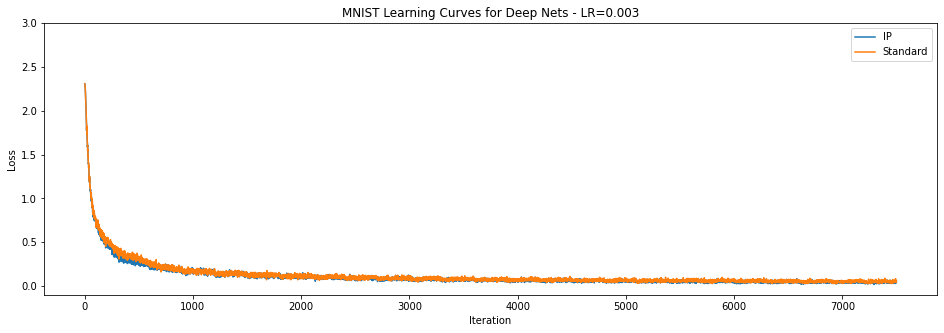

In [30]:
print_save_figure(ipl, spl, "MNIST Learning Curves for Deep Nets - LR={}".format(syn_lr), "IP", "../images/deepm{}.png".format(syn_lr))

In [10]:
syn_lr = 0.01

ipl, spl = run_mnist_experiment(int_lr, syn_lr, epochs, test_runs, './images/deepm2.png')

Training IP Net. Run 1
[1] loss: 0.940
[2] loss: 0.523
[3] loss: 0.342
[4] loss: 0.269
[5] loss: 0.218
[6] loss: 0.189
[7] loss: 0.163
[8] loss: 0.148
[9] loss: 0.134
[10] loss: 0.125
[11] loss: 0.112
[12] loss: 0.110
[13] loss: 0.104
[14] loss: 0.093
[15] loss: 0.087
[16] loss: 0.085
[17] loss: 0.080
[18] loss: 0.075
[19] loss: 0.071
[20] loss: 0.071
[21] loss: 0.067
[22] loss: 0.067
[23] loss: 0.062
[24] loss: 0.059
[25] loss: 0.057
Finished training!

Training Standard Net. Run 1
[1] loss: 0.961
[2] loss: 0.655
[3] loss: 0.538
[4] loss: 0.464
[5] loss: 0.435
[6] loss: 0.401
[10] loss: 0.108
[11] loss: 0.101
[12] loss: 0.093
[13] loss: 0.083
[14] loss: 0.082
[15] loss: 0.078
[16] loss: 0.072
[17] loss: 0.075
[18] loss: 0.072
[19] loss: 0.064
[20] loss: 0.065
[21] loss: 0.061
[22] loss: 0.053
[23] loss: 0.058
[24] loss: 0.055
[25] loss: 0.054
Finished training!

Training Standard Net. Run 2
[1] loss: 1.052
[2] loss: 0.726
[3] loss: 0.482
[4] loss: 0.410
[5] loss: 0.384
[6] loss: 0.409

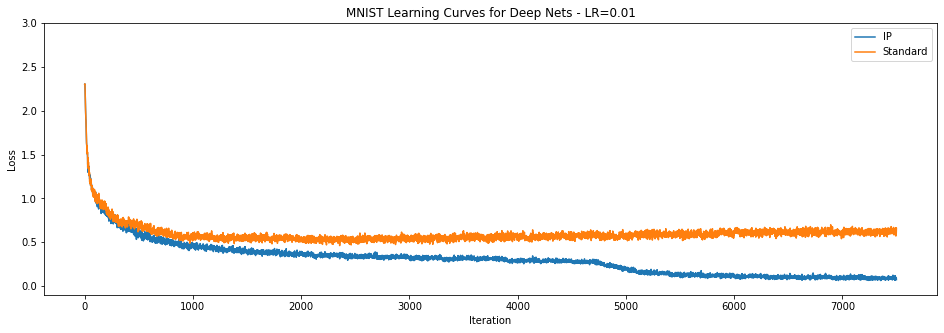

In [11]:
print_save_figure(ipl, spl, "MNIST Learning Curves for Deep Nets - LR={}".format(syn_lr), "IP", "../images/deepm{}.png".format(syn_lr))

In [12]:
syn_lr = 0.012

ipl, spl = run_mnist_experiment(int_lr, syn_lr, epochs, test_runs, './images/deepm3.png')

Training IP Net. Run 1
[1] loss: 2.288
[2] loss: 2.290
[3] loss: 2.310
[4] loss: 2.310
[5] loss: 2.307
[6] loss: 2.310
[7] loss: 2.307
[8] loss: 2.310
[9] loss: 2.289
[10] loss: 2.310
[11] loss: 2.310
[12] loss: 2.310
[13] loss: 2.310
[14] loss: 2.310
[15] loss: 2.310
[16] loss: 2.310
[17] loss: 2.310
[18] loss: 2.277
[19] loss: 2.135
[20] loss: 2.126
[21] loss: 2.115
[22] loss: 2.105
[23] loss: 2.095
[24] loss: 2.080
[25] loss: 2.074
Finished training!

Training Standard Net. Run 1
[1] loss: 2.290
[2] loss: 2.310
[3] loss: 2.310
[4] loss: 2.310
[5] loss: 2.310
[6] loss: 2.310
[7] loss: 2.310
[8] loss: 2.310
[9] loss: 2.310
[10] loss: 2.310
[11] loss: 2.310
[12] loss: 2.310
[13] loss: 2.310
[14] loss: 2.310
[15] loss: 2.310
[16] loss: 2.310
[17] loss: 2.310
[18] loss: 2.310
[19] loss: 2.310
[20] loss: 2.310
[21] loss: 2.310
[22] loss: 2.310
[23] loss: 2.310
[24] loss: 2.310
[25] loss: 2.310
Finished training!

Training IP Net. Run 2
[1] loss: 0.911
[2] loss: 0.495
[3] loss: 0.352
[4] l

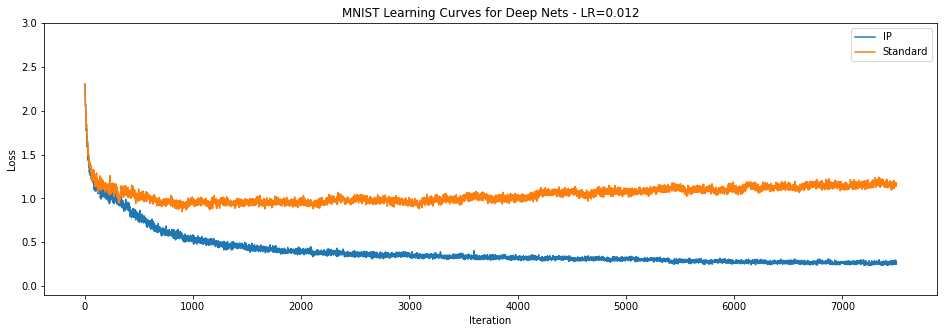

In [13]:
print_save_figure(ipl, spl, "MNIST Learning Curves for Deep Nets - LR={}".format(syn_lr), "IP", "../images/deepm{}.png".format(syn_lr))

# CIFAR-10 Tests

In [14]:
batchSize = 200

transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [15]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 150
epochs = 50

test_runs = 10

int_lr = 0.0001

In [16]:
syn_lr = 0.0006

ipl, spl = run_cifar_experiment(int_lr, syn_lr, epochs, test_runs, './images/deepc1.png')

Training IP Net. Run 1
[1] loss: 2.033
[2] loss: 1.839
[3] loss: 1.768
[4] loss: 1.724
[5] loss: 1.672
[6] loss: 1.625
[7] loss: 1.579
[8] loss: 1.544
[9] loss: 1.510
[10] loss: 1.490
[11] loss: 1.455
[12] loss: 1.438
[13] loss: 1.412
[14] loss: 1.405
[15] loss: 1.386
[16] loss: 1.369
[17] loss: 1.351
[18] loss: 1.333
[19] loss: 1.330
[20] loss: 1.316
[21] loss: 1.312
[22] loss: 1.286
[23] loss: 1.274
[24] loss: 1.263
[25] loss: 1.255
[26] loss: 1.237
[27] loss: 1.238
[28] loss: 1.232
[29] loss: 1.213
[30] loss: 1.207
[31] loss: 1.204
[32] loss: 1.191
[33] loss: 1.174
[34] loss: 1.176
[35] loss: 1.163
[36] loss: 1.165
[37] loss: 1.141
[38] loss: 1.148
[39] loss: 1.142
[40] loss: 1.127
[41] loss: 1.126
[42] loss: 1.109
[43] loss: 1.101
[44] loss: 1.102
[45] loss: 1.101
[46] loss: 1.094
[47] loss: 1.075
[48] loss: 1.076
[49] loss: 1.071
[50] loss: 1.062
Finished training!

Training Standard Net. Run 1
[1] loss: 2.035
[2] loss: 1.837
[3] loss: 1.775
[4] loss: 1.735
[5] loss: 1.688
[6] los

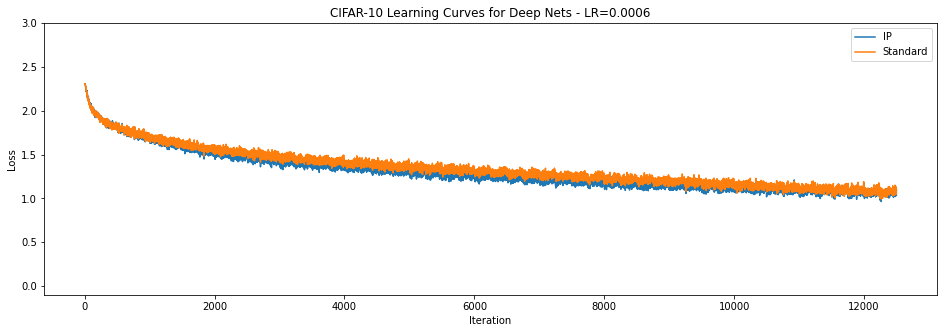

In [17]:
print_save_figure(ipl, spl, "CIFAR-10 Learning Curves for Deep Nets - LR={}".format(syn_lr), "IP", "../images/deepc{}.png".format(syn_lr))

In [18]:
syn_lr = 0.001
ipl, spl = run_cifar_experiment(int_lr, syn_lr, epochs, test_runs, './images/deepc2.png')

Training IP Net. Run 1
[1] loss: 2.038
[2] loss: 1.890
[3] loss: 1.822
[4] loss: 1.762
[5] loss: 1.718
[6] loss: 1.668
[7] loss: 1.645
[8] loss: 1.600
[9] loss: 1.561
[10] loss: 1.538
[11] loss: 1.505
[12] loss: 1.477
[13] loss: 1.446
[14] loss: 1.419
[15] loss: 1.409
[16] loss: 1.401
[17] loss: 1.385
[18] loss: 1.353
[19] loss: 1.337
[20] loss: 1.329
[21] loss: 1.320
[22] loss: 1.297
[23] loss: 1.289
[24] loss: 1.278
[25] loss: 1.254
[26] loss: 1.246
[27] loss: 1.226
[28] loss: 1.226
[29] loss: 1.205
[30] loss: 1.202
[31] loss: 1.190
[32] loss: 1.174
[33] loss: 1.169
[34] loss: 1.152
[35] loss: 1.153
[13] loss: 1.565
[14] loss: 1.541
[15] loss: 1.531
[16] loss: 1.527
[17] loss: 1.520
[18] loss: 1.511
[19] loss: 1.494
[20] loss: 1.486
[21] loss: 1.478
[22] loss: 1.476
[23] loss: 1.464
[24] loss: 1.452
[25] loss: 1.447
[26] loss: 1.441
[27] loss: 1.429
[28] loss: 1.430
[29] loss: 1.412
[30] loss: 1.421
[31] loss: 1.397
[32] loss: 1.391
[33] loss: 1.384
[34] loss: 1.384
[35] loss: 1.376


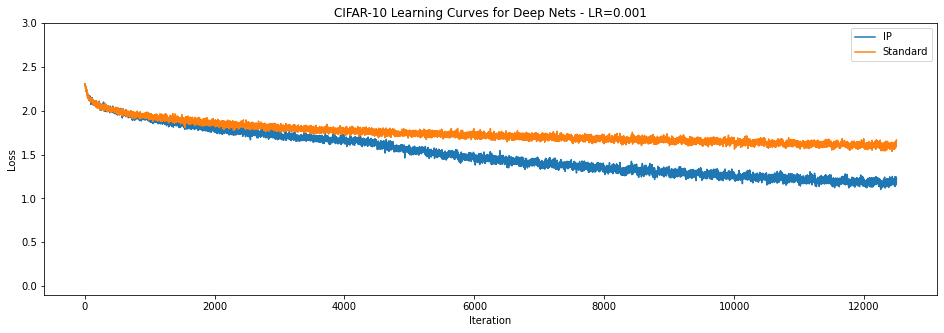

In [19]:
print_save_figure(ipl, spl, "CIFAR-10 Learning Curves for Deep Nets - LR={}".format(syn_lr), "IP", "../images/deepc{}.png".format(syn_lr))

In [20]:
syn_lr = 0.0013

ipl, spl = run_cifar_experiment(int_lr, syn_lr, epochs, test_runs, './images/deepc3.png')

Training IP Net. Run 1
[1] loss: 2.057
[2] loss: 1.907
[3] loss: 1.853
[4] loss: 1.811
[5] loss: 1.762
[6] loss: 1.701
[7] loss: 1.668
[8] loss: 1.627
[9] loss: 1.582
[10] loss: 1.552
[11] loss: 1.533
[12] loss: 1.500
[13] loss: 1.473
[14] loss: 1.444
[15] loss: 1.427
[16] loss: 1.416
[17] loss: 1.395
[18] loss: 1.374
[19] loss: 1.359
[20] loss: 1.344
[21] loss: 1.329
[22] loss: 1.311
[23] loss: 1.304
[24] loss: 1.277
[25] loss: 1.257
[26] loss: 1.241
[27] loss: 1.231
[28] loss: 1.211
[29] loss: 1.197
[30] loss: 1.180
[31] loss: 1.152
[32] loss: 1.143
[33] loss: 1.138
[34] loss: 1.122
[35] loss: 1.102
[36] loss: 1.092
[37] loss: 1.071
[38] loss: 1.074
[39] loss: 1.056
[40] loss: 1.047
[41] loss: 1.029
[42] loss: 1.013
[43] loss: 1.019
[44] loss: 1.003
[45] loss: 0.997
[46] loss: 0.977
[47] loss: 0.973
[48] loss: 0.974
[49] loss: 0.948
[50] loss: 0.957
Finished training!

Training Standard Net. Run 1
[1] loss: 2.068
[2] loss: 1.914
[3] loss: 1.878
[4] loss: 1.831
[5] loss: 1.819
[6] los

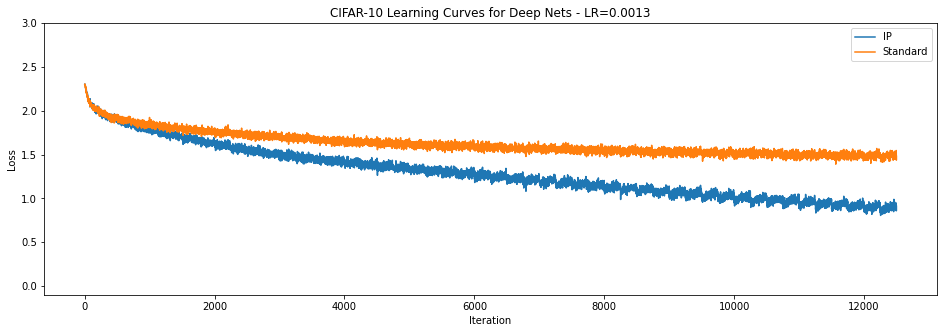

In [21]:
print_save_figure(ipl, spl, "CIFAR-10 Learning Curves for Deep Nets - LR={}".format(syn_lr), "IP", "../images/deepc{}.png".format(syn_lr))